https://github.com/zllrunning/face-makeup.PyTorch

# library

In [ ]:
import cv2
import os
import numpy as np
from skimage.filters import gaussian

from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

In [ ]:
def sharpen(img):
    img = img * 1.0
    gauss_out = gaussian(img, sigma=5, multichannel=True)

    alpha = 1.5
    img_out = (img - gauss_out) * alpha + img

    img_out = img_out / 255.0

    mask_1 = img_out < 0
    mask_2 = img_out > 1

    img_out = img_out * (1 - mask_1)
    img_out = img_out * (1 - mask_2) + mask_2
    img_out = np.clip(img_out, 0, 1)
    img_out = img_out * 255
    return np.array(img_out, dtype=np.uint8)

In [ ]:
def hair(image, parsing, part=17, color=[230, 50, 20]):
    b, g, r = color      #[10, 50, 250]       # [10, 250, 10]
    tar_color = np.zeros_like(image)
    tar_color[:, :, 0] = b
    tar_color[:, :, 1] = g
    tar_color[:, :, 2] = r

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    tar_hsv = cv2.cvtColor(tar_color, cv2.COLOR_BGR2HSV)

    if part == 12 or part == 13:
        image_hsv[:, :, 0:2] = tar_hsv[:, :, 0:2]
    else:
        image_hsv[:, :, 0:1] = tar_hsv[:, :, 0:1]

    changed = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)

    if part == 17:
        changed = sharpen(changed)

    changed[parsing != part] = image[parsing != part]
    return changed

In [ ]:
# 1  face
# 11 teeth
# 12 upper lip
# 13 lower lip
# 17 hair

table = {
    'face': 1,
    'nose': 4,
    'hair': 17,
    'upper_lip': 12,
    'lower_lip': 13
}


# resnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as modelzoo

# from modules.bn import InPlaceABNSync as BatchNorm2d

resnet18_url = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, in_chan, out_chan, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_chan, out_chan, stride)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.conv2 = conv3x3(out_chan, out_chan)
        self.bn2 = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if in_chan != out_chan or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_chan, out_chan,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_chan),
                )

    def forward(self, x):
        residual = self.conv1(x)
        residual = F.relu(self.bn1(residual))
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)

        out = shortcut + residual
        out = self.relu(out)
        return out


def create_layer_basic(in_chan, out_chan, bnum, stride=1):
    layers = [BasicBlock(in_chan, out_chan, stride=stride)]
    for i in range(bnum-1):
        layers.append(BasicBlock(out_chan, out_chan, stride=1))
    return nn.Sequential(*layers)


class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = create_layer_basic(64, 64, bnum=2, stride=1)
        self.layer2 = create_layer_basic(64, 128, bnum=2, stride=2)
        self.layer3 = create_layer_basic(128, 256, bnum=2, stride=2)
        self.layer4 = create_layer_basic(256, 512, bnum=2, stride=2)
        self.init_weight()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool(x)

        x = self.layer1(x)
        feat8 = self.layer2(x) # 1/8
        feat16 = self.layer3(feat8) # 1/16
        feat32 = self.layer4(feat16) # 1/32
        return feat8, feat16, feat32

    def init_weight(self):
        state_dict = modelzoo.load_url(resnet18_url)
        self_state_dict = self.state_dict()
        for k, v in state_dict.items():
            if 'fc' in k: continue
            self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module,  nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


# model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# from modules.bn import InPlaceABNSync as BatchNorm2d


class ConvBNReLU(nn.Module):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan,
                out_chan,
                kernel_size = ks,
                stride = stride,
                padding = padding,
                bias = False)
        self.bn = nn.BatchNorm2d(out_chan)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(self.bn(x))
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

class BiSeNetOutput(nn.Module):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, ks=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(mid_chan, n_classes, kernel_size=1, bias=False)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_out(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class AttentionRefinementModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        self.conv = ConvBNReLU(in_chan, out_chan, ks=3, stride=1, padding=1)
        self.conv_atten = nn.Conv2d(out_chan, out_chan, kernel_size= 1, bias=False)
        self.bn_atten = nn.BatchNorm2d(out_chan)
        self.sigmoid_atten = nn.Sigmoid()
        self.init_weight()

    def forward(self, x):
        feat = self.conv(x)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        out = torch.mul(feat, atten)
        return out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class ContextPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ContextPath, self).__init__()
        self.resnet = Resnet18()
        self.arm16 = AttentionRefinementModule(256, 128)
        self.arm32 = AttentionRefinementModule(512, 128)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_avg = ConvBNReLU(512, 128, ks=1, stride=1, padding=0)

        self.init_weight()

    def forward(self, x):
        H0, W0 = x.size()[2:]
        feat8, feat16, feat32 = self.resnet(x)
        H8, W8 = feat8.size()[2:]
        H16, W16 = feat16.size()[2:]
        H32, W32 = feat32.size()[2:]

        avg = F.avg_pool2d(feat32, feat32.size()[2:])
        avg = self.conv_avg(avg)
        avg_up = F.interpolate(avg, (H32, W32), mode='nearest')

        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg_up
        feat32_up = F.interpolate(feat32_sum, (H16, W16), mode='nearest')
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = F.interpolate(feat16_sum, (H8, W8), mode='nearest')
        feat16_up = self.conv_head16(feat16_up)

        return feat8, feat16_up, feat32_up  # x8, x8, x16

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


### This is not used, since I replace this with the resnet feature with the same size
class SpatialPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(SpatialPath, self).__init__()
        self.conv1 = ConvBNReLU(3, 64, ks=7, stride=2, padding=3)
        self.conv2 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv3 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv_out = ConvBNReLU(64, 128, ks=1, stride=1, padding=0)
        self.init_weight()

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.conv2(feat)
        feat = self.conv3(feat)
        feat = self.conv_out(feat)
        return feat

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class FeatureFusionModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        self.convblk = ConvBNReLU(in_chan, out_chan, ks=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(out_chan,
                out_chan//4,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.conv2 = nn.Conv2d(out_chan//4,
                out_chan,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()

    def forward(self, fsp, fcp):
        fcat = torch.cat([fsp, fcp], dim=1)
        feat = self.convblk(fcat)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv1(atten)
        atten = self.relu(atten)
        atten = self.conv2(atten)
        atten = self.sigmoid(atten)
        feat_atten = torch.mul(feat, atten)
        feat_out = feat_atten + feat
        return feat_out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class BiSeNet(nn.Module):
    def __init__(self, n_classes, *args, **kwargs):
        super(BiSeNet, self).__init__()
        self.cp = ContextPath()
        ## here self.sp is deleted
        self.ffm = FeatureFusionModule(256, 256)
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(128, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(128, 64, n_classes)
        self.init_weight()

    def forward(self, x):
        H, W = x.size()[2:]
        feat_res8, feat_cp8, feat_cp16 = self.cp(x)  # here return res3b1 feature
        feat_sp = feat_res8  # use res3b1 feature to replace spatial path feature
        feat_fuse = self.ffm(feat_sp, feat_cp8)

        feat_out = self.conv_out(feat_fuse)
        feat_out16 = self.conv_out16(feat_cp8)
        feat_out32 = self.conv_out32(feat_cp16)

        feat_out = F.interpolate(feat_out, (H, W), mode='bilinear', align_corners=True)
        feat_out16 = F.interpolate(feat_out16, (H, W), mode='bilinear', align_corners=True)
        feat_out32 = F.interpolate(feat_out32, (H, W), mode='bilinear', align_corners=True)
        return feat_out, feat_out16, feat_out32

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, FeatureFusionModule) or isinstance(child, BiSeNetOutput):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params

# evaluate

In [ ]:
import torch
import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2


def vis_parsing_maps(im, parsing_anno, stride, save_im=False, save_path='vis_results/parsing_map_on_im.jpg'):
    # Colors for all 20 parts
    part_colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0],
                   [255, 0, 85], [255, 0, 170],
                   [0, 255, 0], [85, 255, 0], [170, 255, 0],
                   [0, 255, 85], [0, 255, 170],
                   [0, 0, 255], [85, 0, 255], [170, 0, 255],
                   [0, 85, 255], [0, 170, 255],
                   [255, 255, 0], [255, 255, 85], [255, 255, 170],
                   [255, 0, 255], [255, 85, 255], [255, 170, 255],
                   [0, 255, 255], [85, 255, 255], [170, 255, 255]]

    im = np.array(im)
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    vis_parsing_anno = cv2.resize(vis_parsing_anno, None, fx=stride, fy=stride, interpolation=cv2.INTER_NEAREST)
    vis_parsing_anno_color = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 3)) + 255

    num_of_class = np.max(vis_parsing_anno)

    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)
        vis_parsing_anno_color[index[0], index[1], :] = part_colors[pi]

    vis_parsing_anno_color = vis_parsing_anno_color.astype(np.uint8)
    # print(vis_parsing_anno_color.shape, vis_im.shape)
    vis_im = cv2.addWeighted(cv2.cvtColor(vis_im, cv2.COLOR_RGB2BGR), 0.4, vis_parsing_anno_color, 0.6, 0)

    # Save result or not
    if save_im:
        cv2.imwrite(save_path[:-4] +'.png', vis_parsing_anno)
        cv2.imwrite(save_path, vis_im, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    return vis_parsing_anno
    # return vis_im


def evaluate(image_path='./imgs/116.jpg', cp='cp/79999_iter.pth'):

    # if not os.path.exists(respth):
    #     os.makedirs(respth)

    n_classes = 19
    net = BiSeNet(n_classes=n_classes)
    net.cuda()
    net.load_state_dict(torch.load(cp))
    net.eval()

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    with torch.no_grad():
        img = Image.open(image_path)
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        # print(parsing)
        # print(np.unique(parsing))

        # vis_parsing_maps(image, parsing, stride=1, save_im=False, save_path=osp.join(respth, dspth))
        return parsing

(1024, 1024, 3)


<ipython-input-2-5fc4b16055ef>:3: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  gauss_out = gaussian(img, sigma=5, multichannel=True)


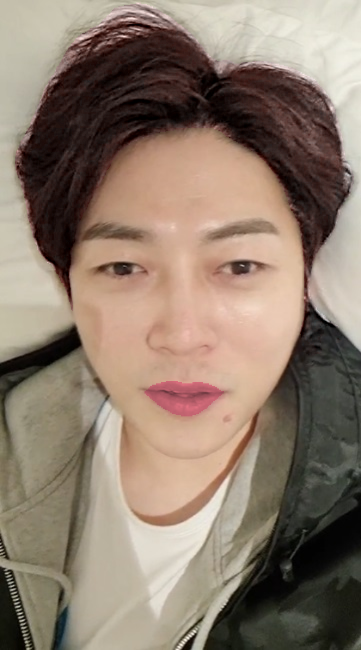

In [ ]:
image_path = '/content/neck.jpg'
cp = '/content/79999_iter.pth'

image = cv2.imread(image_path)

image = cv2.resize(image, (1024,1024))

ori = image.copy()

parsing = evaluate(image_path, cp)

parsing = cv2.resize(parsing, image.shape[0:2], interpolation=cv2.INTER_NEAREST)

parts = [table['hair'], table['upper_lip'], table['lower_lip']]

colors = [[21,41,167], [144,128,250], [144,128,250]] #B,G,R

for part, color in zip(parts, colors):
    image = hair(image, parsing, part, color)

ori = cv2.resize(ori,(512,512))
image = cv2.resize(image, (361,650))

cv2_imshow(image)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
cv2.imwrite('convert.jpg',image)

True